In [22]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import sympy as sm

Below is a diagram of the system we want to simulate.

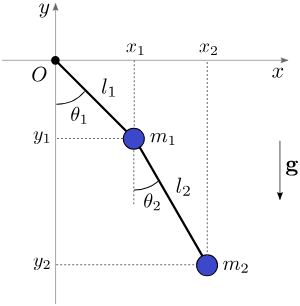

The first step is to define our variables, which are {$m_1$, $m_2$, $g$, $\theta_1$, $\theta_2$, $x_1$, $x_2$, $y_1$, $y_2$}. We can do this cleanly using sympy.symbols( ).

In [55]:
t = sm.symbols('t')
m_1, m_2, g = sm.symbols('m₁ m₂ g', positive = True)
the1, the2  = sm.symbols('θ₁, θ₂', cls = sm.Function)

the1 = the1(t)
the2 = the2(t)

x1 = sm.sin(the1)
y1 = -sm.cos(the1)

x2 = x1 + sm.sin(the2)
y2 = y1 + -sm.cos(the2)

Now we will compute the first and second derivatives of $\theta_i$: $\frac{d\theta_i}{dt}$ and $\frac{d^2 \theta_i}{dt^2}$. We will also compute the first and second derivatives of $x_i$ and $y_i$: $v_{x_i}$ and $v_{y_i}$ as we will need these to calculate the energies. 

$i = \left\{1,2\right\}$ for the first and second mass respectively.

In [56]:
the1_d  = sm.diff(the1, t) # Angular velocity
the1_dd = sm.diff(the1_d, t) # Angular acceleration

x1_d = sm.diff(x1, t)
y1_d = sm.diff(y1, t)

the2_d  = sm.diff(the2, t)
the2_dd = sm.diff(the2_d, t)

x2_d = sm.diff(x2, t)
y2_d = sm.diff(y2, t)

The kinetic energy of the masses is given by

$T_i = \frac{1}{2}m_{i}\left(x_i^2 + y_i^2\right)$,

and the potential energies are given by

$V_i = m_i g y_i$.

These can then used to calculate the Lagrangian which is given by

$L = T - V$,

where $T$ and $V$ are the total kinetic and potential energy respectively (the sum of the aforementioned results).


In [57]:
# Kinetc Energies
T1 = 0.5 * m_1 * (x1_d**2 + y1_d**2)
T2 = 0.5 * m_2 * (x2_d**2 + y2_d**2)

# Potential Energies
V1 = m_1 * g * y1
V2 = m_2 * g * y2

L = T1 + T2 - V1 - V2 # Lagrangian

To obtain our system of differential equations, we substitute our Lagrangian into the Euler-Lagrange equations for each mass which are given by

$\frac{d}{dt}\left(\frac{dL}{d\dot{\theta}_1}\right) - \frac{dL}{d\theta_1} = 0$ \
$\frac{d}{dt}\left(\frac{dL}{d\dot{\theta}_2}\right) - \frac{dL}{d\theta_2} = 0$ \

To do this, we can use sm.diff( ) to get the Lagrange equations for mass 1 and mass 2 and define them as LE1 and LE2. We then solve the obtained equations for $\frac{d^2 \theta_i}{dt^2}$ to obtain 

$\frac{d^2 \theta_1}{dt^2} = ...$ \
$\frac{d^2 \theta_2}{dt^2} = ...$ 

In [69]:
LE1 = sm.diff(sm.diff(L, the1_d), t) - sm.diff(L, the1)
LE2 = sm.diff(sm.diff(L, the2_d), t) - sm.diff(L, the2)

LE1 = EL1.simplify()
LE2 = EL2.simplify()

In [71]:
sols = sm.solve([LE1, LE2], the1_dd, the2_dd)

LEF1 = sm.lambdify((the1, the2, the1_d, the2_d, t, m_1, m_2, g), sols[the1_dd])
LEF2 = sm.lambdify((the1, the2, the1_d, the2_d, t, m_1, m_2, g), sols[the2_dd])

In [116]:
initial_conditions = [1.0, 0.0, 1.0, 0.0] # angle_1, velocity_1, angle_2, velocity_2
m1_value = 2.0
m2_value = 4.0
g_value  = 9.81

def ode_system(y, t, m_1, m_2, g):
    the1, the1_d, the2, the2_d = y

    the1_dd = LEF1(the1, the2, the1_d, the2_d, t, m_1, m_2, g)
    the2_dd = LEF2(the1, the2, the1_d, the2_d, t, m_1, m_2, g)

    return [the1_d, the1_dd, the2_d, the2_dd]

# Time interval for simulation
t_interval = np.linspace(0, 40, 1000)

# Solving system of ODEs
solutions = odeint(ode_system, initial_conditions, t_interval, args = (m1_value, m2_value, g_value))

# Extracting angles and angular velocities
the1_sol   = solutions[:, 0]
the1_d_sol = solutions[:, 1]

the2_sol   = solutions[:, 2]
the2_d_sol = solutions[:, 3]

x1 = np.sin(the1_sol)
y1 = -np.cos(the1_sol)

x2 = x1 + np.sin(the2_sol)
y2 = y1 + -np.cos(the2_sol)

We will now animate the double pendulum using the solutions we obtained

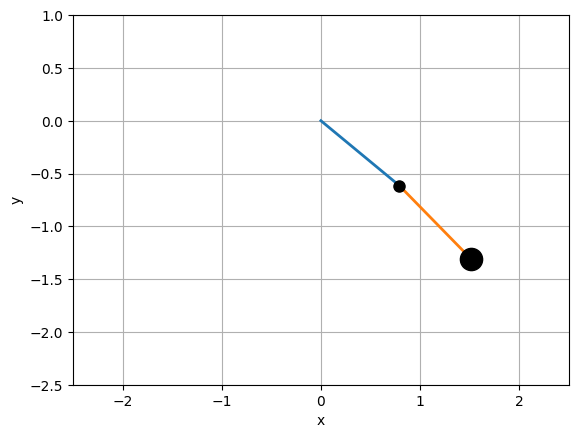

In [118]:
fig, ax = plt.subplots()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.grid()

def update(frame):
    pendulum1.set_data([0, x1[frame]], [0, y1[frame]])
    pendulum2.set_data([x1[frame], x2[frame]], [y1[frame], y2[frame]])

    mass1.set_data([x1[frame]], [y1[frame]])
    mass2.set_data([x2[frame]], [y2[frame]])

    return pendulum1, mass1, pendulum2, mass2

pendulum1, = ax.plot([0, x1[0]], [0, y1[0]], lw = 2)
pendulum2, = ax.plot([x1[0], x2[0]], [y1[0], y2[0]], lw = 2)

mass1, = ax.plot([x1[0]], [y1[0]], 'o', markersize = 4*int(m1_value), color = 'black')
mass2, = ax.plot([x2[0]], [y2[0]], 'o', markersize = 4*int(m2_value), color = 'black')

ani = FuncAnimation(fig, update, frames = len(t_interval), interval = 25, blit = True)

HTML(ani.to_html5_video())